In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data/BinaryClassification_image/"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../data/BinaryClassification_image/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('../data/BinaryClassification_image/')
    
print('After zip extraction:')
print(os.listdir("../data/BinaryClassification_image/"))

['plates', 'plates.zip', 'submission.csv', '__MACOSX']
After zip extraction:
['plates', 'plates.zip', 'submission.csv', '__MACOSX']


In [2]:
data_root = '../data/BinaryClassification_image/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 1235.16it/s]


In [4]:
!ls train

cleaned
dirty


In [12]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [6]:
len(train_dataloader), len(train_dataset)

(5, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


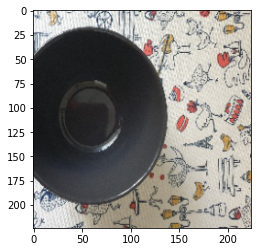

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

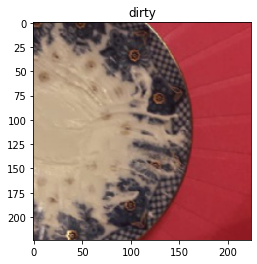

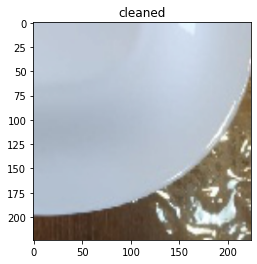

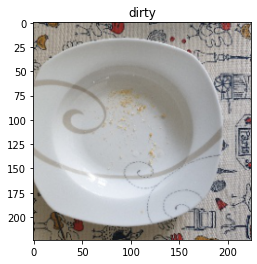

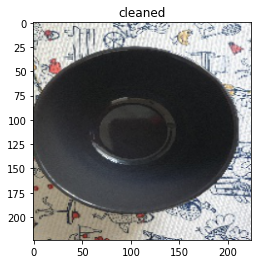

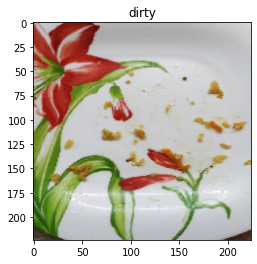

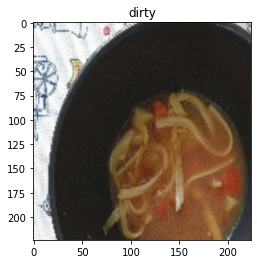

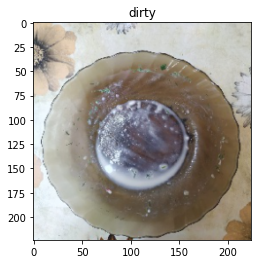

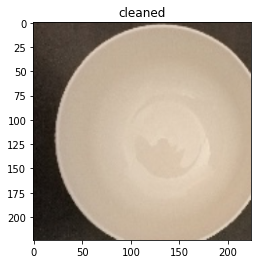

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [30]:
model = models.regnet_y_3_2gf(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/regnet_y_3_2gf-b5a9779c.pth" to C:\Users\user/.cache\torch\hub\checkpoints\regnet_y_3_2gf-b5a9779c.pth
100%|██████████| 74.6M/74.6M [00:05<00:00, 14.0MB/s]


In [31]:
train_model(model, loss, optimizer, scheduler, 100)

Epoch 0/99:


c:\Users\user\anaconda3\envs\torch17\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

train Loss: 0.7541 Acc: 0.4250



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.7034 Acc: 0.8333
Epoch 1/99:



100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

train Loss: 0.6117 Acc: 0.7000



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

val Loss: 0.6969 Acc: 0.6667
Epoch 2/99:



100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

train Loss: 0.6526 Acc: 0.6750



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6405 Acc: 0.6667
Epoch 3/99:



100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

train Loss: 0.6239 Acc: 0.6250



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

val Loss: 0.6308 Acc: 0.6667
Epoch 4/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.4716 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.8214 Acc: 0.5000
Epoch 5/99:



100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

train Loss: 0.5367 Acc: 0.7250



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

val Loss: 0.7144 Acc: 0.5000
Epoch 6/99:



100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

train Loss: 0.4831 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.7165 Acc: 0.3333
Epoch 7/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4603 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

val Loss: 0.7151 Acc: 0.3333
Epoch 8/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.4889 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.7246 Acc: 0.3333
Epoch 9/99:



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

train Loss: 0.4879 Acc: 0.7000



100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

val Loss: 0.6799 Acc: 0.3333
Epoch 10/99:



100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

train Loss: 0.3914 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6601 Acc: 0.5000
Epoch 11/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.3849 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

val Loss: 0.6570 Acc: 0.5000
Epoch 12/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.5440 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6347 Acc: 0.5000
Epoch 13/99:



100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

train Loss: 0.4761 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

val Loss: 0.6503 Acc: 0.5000
Epoch 14/99:



100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

train Loss: 0.4799 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6372 Acc: 0.5000
Epoch 15/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4348 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6434 Acc: 0.5000
Epoch 16/99:



100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

train Loss: 0.4523 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6285 Acc: 0.5000
Epoch 17/99:



100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

train Loss: 0.4565 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.5978 Acc: 0.6667
Epoch 18/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4775 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6057 Acc: 0.6667
Epoch 19/99:



100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

train Loss: 0.4570 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

val Loss: 0.6174 Acc: 0.6667
Epoch 20/99:



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

train Loss: 0.4162 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6122 Acc: 0.5000
Epoch 21/99:



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

train Loss: 0.4465 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6279 Acc: 0.5000
Epoch 22/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.4782 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6132 Acc: 0.5000
Epoch 23/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.5281 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6326 Acc: 0.5000
Epoch 24/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.4606 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6391 Acc: 0.5000
Epoch 25/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.4298 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.5920 Acc: 0.5000
Epoch 26/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4695 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6121 Acc: 0.5000
Epoch 27/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.5195 Acc: 0.7000



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6148 Acc: 0.5000
Epoch 28/99:



100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

train Loss: 0.4778 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

val Loss: 0.6289 Acc: 0.5000
Epoch 29/99:



100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

train Loss: 0.4482 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6417 Acc: 0.5000
Epoch 30/99:



100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

train Loss: 0.3568 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6888 Acc: 0.3333
Epoch 31/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.4870 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6319 Acc: 0.5000
Epoch 32/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4978 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6521 Acc: 0.5000
Epoch 33/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4686 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6473 Acc: 0.5000
Epoch 34/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.4546 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6407 Acc: 0.5000
Epoch 35/99:



100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

train Loss: 0.4067 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6465 Acc: 0.5000
Epoch 36/99:



100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

train Loss: 0.4484 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6417 Acc: 0.5000
Epoch 37/99:



100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

train Loss: 0.4983 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6259 Acc: 0.5000
Epoch 38/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4622 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6520 Acc: 0.3333
Epoch 39/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4346 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6800 Acc: 0.3333
Epoch 40/99:



100%|██████████| 5/5 [00:01<00:00,  3.83it/s]

train Loss: 0.3878 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6658 Acc: 0.5000
Epoch 41/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.5093 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6258 Acc: 0.5000
Epoch 42/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4136 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6448 Acc: 0.5000
Epoch 43/99:



100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

train Loss: 0.5088 Acc: 0.6750



100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

val Loss: 0.6391 Acc: 0.5000
Epoch 44/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.3994 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6389 Acc: 0.5000
Epoch 45/99:



100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

train Loss: 0.5210 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

val Loss: 0.6405 Acc: 0.5000
Epoch 46/99:



100%|██████████| 5/5 [00:01<00:00,  3.59it/s]

train Loss: 0.4525 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6443 Acc: 0.5000
Epoch 47/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4835 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6407 Acc: 0.5000
Epoch 48/99:



100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

train Loss: 0.4703 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6089 Acc: 0.5000
Epoch 49/99:



100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

train Loss: 0.4541 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.5915 Acc: 0.6667
Epoch 50/99:



100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

train Loss: 0.4243 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

val Loss: 0.6151 Acc: 0.6667
Epoch 51/99:



100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

train Loss: 0.4127 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

val Loss: 0.6330 Acc: 0.5000
Epoch 52/99:



100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

train Loss: 0.4176 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6507 Acc: 0.5000
Epoch 53/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.5241 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6079 Acc: 0.6667
Epoch 54/99:



100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

train Loss: 0.3604 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6221 Acc: 0.5000
Epoch 55/99:



100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

train Loss: 0.4446 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6297 Acc: 0.5000
Epoch 56/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4405 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6189 Acc: 0.5000
Epoch 57/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.4129 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6157 Acc: 0.5000
Epoch 58/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.3878 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6128 Acc: 0.6667
Epoch 59/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4927 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6513 Acc: 0.5000
Epoch 60/99:



100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

train Loss: 0.4789 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6684 Acc: 0.5000
Epoch 61/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.3883 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6492 Acc: 0.3333
Epoch 62/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.4853 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6252 Acc: 0.6667
Epoch 63/99:



100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

train Loss: 0.4168 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6403 Acc: 0.6667
Epoch 64/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4889 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6340 Acc: 0.5000
Epoch 65/99:



100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

train Loss: 0.4062 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6229 Acc: 0.5000
Epoch 66/99:



100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

train Loss: 0.4044 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6232 Acc: 0.5000
Epoch 67/99:



100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

train Loss: 0.5345 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6174 Acc: 0.5000
Epoch 68/99:



100%|██████████| 5/5 [00:01<00:00,  3.67it/s]

train Loss: 0.5206 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6292 Acc: 0.5000
Epoch 69/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.3920 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6104 Acc: 0.5000
Epoch 70/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4096 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6033 Acc: 0.5000
Epoch 71/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.5023 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6134 Acc: 0.6667
Epoch 72/99:



100%|██████████| 5/5 [00:01<00:00,  3.68it/s]

train Loss: 0.4004 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

val Loss: 0.6202 Acc: 0.6667
Epoch 73/99:



100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

train Loss: 0.4295 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

val Loss: 0.6242 Acc: 0.6667
Epoch 74/99:



100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

train Loss: 0.4884 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6457 Acc: 0.6667
Epoch 75/99:



100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

train Loss: 0.4667 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

val Loss: 0.6219 Acc: 0.6667
Epoch 76/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4390 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6786 Acc: 0.5000
Epoch 77/99:



100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

train Loss: 0.4330 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

val Loss: 0.6683 Acc: 0.5000
Epoch 78/99:



100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

train Loss: 0.4878 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6403 Acc: 0.5000
Epoch 79/99:



100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

train Loss: 0.4003 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

val Loss: 0.6265 Acc: 0.6667
Epoch 80/99:



100%|██████████| 5/5 [00:01<00:00,  3.60it/s]

train Loss: 0.4004 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.5970 Acc: 0.6667
Epoch 81/99:



100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

train Loss: 0.3819 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6189 Acc: 0.5000
Epoch 82/99:



100%|██████████| 5/5 [00:01<00:00,  3.55it/s]

train Loss: 0.4446 Acc: 0.7250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6130 Acc: 0.5000
Epoch 83/99:



100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

train Loss: 0.3788 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6401 Acc: 0.5000
Epoch 84/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.4942 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

val Loss: 0.6352 Acc: 0.5000
Epoch 85/99:



100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

train Loss: 0.4039 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6483 Acc: 0.5000
Epoch 86/99:



100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

train Loss: 0.3851 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.5993 Acc: 0.5000
Epoch 87/99:



100%|██████████| 5/5 [00:01<00:00,  3.29it/s]

train Loss: 0.4018 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6166 Acc: 0.5000
Epoch 88/99:



100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

train Loss: 0.4643 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6513 Acc: 0.3333
Epoch 89/99:



100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

train Loss: 0.4996 Acc: 0.8500



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6365 Acc: 0.5000
Epoch 90/99:



100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

train Loss: 0.4954 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

val Loss: 0.6053 Acc: 0.5000
Epoch 91/99:



100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

train Loss: 0.3541 Acc: 0.9750



100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

val Loss: 0.6522 Acc: 0.5000
Epoch 92/99:



100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

train Loss: 0.5220 Acc: 0.7750



100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

val Loss: 0.6373 Acc: 0.5000
Epoch 93/99:



100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

train Loss: 0.4040 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6238 Acc: 0.5000
Epoch 94/99:



100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

train Loss: 0.4566 Acc: 0.9000



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

val Loss: 0.6685 Acc: 0.5000
Epoch 95/99:



100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

train Loss: 0.4475 Acc: 0.9500



100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

val Loss: 0.6666 Acc: 0.5000
Epoch 96/99:



100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

train Loss: 0.4259 Acc: 0.8250



100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

val Loss: 0.6496 Acc: 0.5000
Epoch 97/99:



100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

train Loss: 0.4558 Acc: 0.8000



100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

val Loss: 0.6530 Acc: 0.5000
Epoch 98/99:



100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

train Loss: 0.4104 Acc: 0.9250



100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

val Loss: 0.6295 Acc: 0.5000
Epoch 99/99:



100%|██████████| 5/5 [00:01<00:00,  3.58it/s]

train Loss: 0.4545 Acc: 0.7250



100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

val Loss: 0.6059 Acc: 0.5000


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): ConvNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): ConvNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): ConvNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (1): B

In [14]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [22]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('C:/Workspace/DeepLearningTutorial/BinaryClassification_image/test/', val_transforms)
# test_dataset = ImageFolderWithPaths('C:/Workspace/DeepLearningTutorial/data/BinaryClassification_image/plates/test/', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [23]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [32]:
model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
    )
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 25.74it/s]


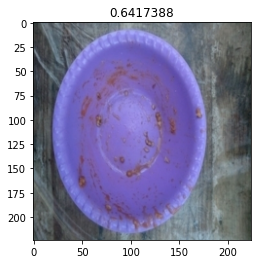

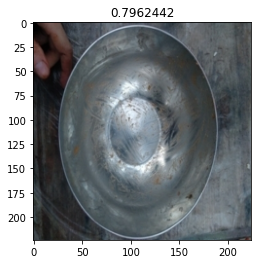

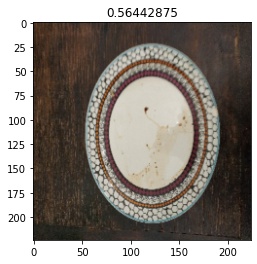

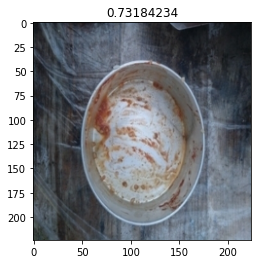

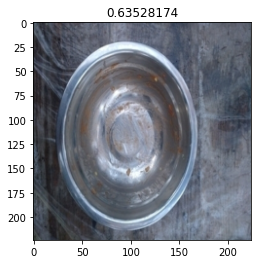

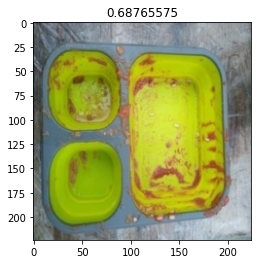

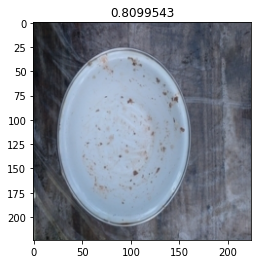

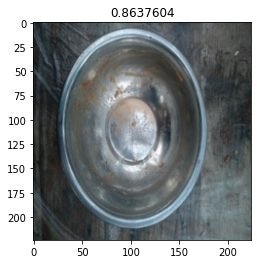

In [33]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [34]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [35]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21684\2226071996.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0000,dirty
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0001,dirty
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0002,dirty
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0003,dirty
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0004,dirty
C:/Workspace/DeepLearningTutorial/BinaryClassification_csv/test/unknown\0005,dirty


In [36]:
submission_df.to_csv('submission.csv')

In [1]:
!rm -rf train val test

In [2]:
!rm submission.csv